In [2]:
import torch
import torch.nn.functional as F

# Network parameters
timesteps = 10
input_size = 2  # Two layers
hidden_size = 2  # Two layers
batch_size = 1

# Initialize activations and inputs for two layers
h_init = torch.randn(batch_size, hidden_size)  # Initial activations h_1(0), h_2(0)
inputs = torch.randn(batch_size, timesteps, hidden_size)  # Inputs I_1(t), I_2(t)

# Define the connection matrix A (self-decay + inter-layer connections)
# A = [[alpha1, beta1],
#      [beta2, alpha2]]
A = torch.tensor([[0.9, 0.1],  # alpha1 = 0.9, beta1 = 0.1
                  [0.2, 0.8]])  # beta2 = 0.2, alpha2 = 0.8

# Step 1: Exponentially decay the initial state using matrix exponential
# h(t) = exp(A * t) * h(0)
exp_A = torch.matrix_exp(A)  # Matrix exponential of A
h_exp = torch.matmul(exp_A, h_init.T).T  # Decayed initial state

# Step 2: Fully parallelized convolution to handle the input contribution over time

# Reshape inputs to be batch x channels x timesteps for conv1d
inputs = inputs.permute(0, 2, 1)  # Now it's [batch_size, layers (channels), timesteps]

# Compute the decay filter
decay_filter = torch.exp(-torch.arange(timesteps).float()).view(1, 1, -1)  # Shape [1, 1, timesteps]

# Perform convolution over all layers at once
input_contribution = F.conv1d(inputs, decay_filter, padding=timesteps-1)

# Combine decayed initial state and input contributions
h_total = h_exp.unsqueeze(1) + input_contribution.permute(0, 2, 1)  # Combine along the time axis

# Output activations for each layer across all time steps
print("Activations across time for both layers:")
print(h_total)


RuntimeError: Given groups=1, weight of size [1, 1, 10], expected input[1, 2, 10] to have 1 channels, but got 2 channels instead

In [15]:
import torch
import torch.nn as nn
import torch.linalg as linalg

# Initial setup
timesteps = 10
input_size = 2  # 2 layers
hidden_size = 2  # 2 neurons (one in each layer)

# Define the interaction matrix B
B = torch.tensor([[0.0, 0.5], [0.5, 0.0]])  # Interaction between the two layers
assert B.shape == (hidden_size, hidden_size), f"Expected B to have shape {(hidden_size, hidden_size)}, got {B.shape}"

# Initial states
h_0 = torch.tensor([1.0, 1.0])  # Initial state for both layers
assert h_0.shape == (hidden_size,), f"Expected h_0 to have shape {(hidden_size,)}, got {h_0.shape}"

# Define decay matrix D (diagonal, no interaction, just decay)
decay_factors = torch.tensor([0.9, 0.8])  # Decay constants for the two layers
D = torch.diag(decay_factors)
assert D.shape == (hidden_size, hidden_size), f"Expected D to have shape {(hidden_size, hidden_size)}, got {D.shape}"

# Define input currents over time (just for example purposes, static input here)
I = torch.ones((timesteps, input_size))
assert I.shape == (timesteps, input_size), f"Expected I to have shape {(timesteps, input_size)}, got {I.shape}"

# Iterative Approach (Ground Truth)
def iterative_computation(h_0, B, D, I, timesteps):
    h = h_0.clone()
    states = [h_0]  # Store the states over time
    for t in range(1, timesteps):
        # Compute new state with interaction, decay, and input
        h = B @ h + D @ h + torch.sum(I[:t], dim=0)  # Interaction + decay + cumulative input
        assert h.shape == (hidden_size,), f"Expected h to have shape {(hidden_size,)}, got {h.shape}"
        states.append(h)
    result = torch.stack(states)  # Return all states over time
    assert result.shape == (timesteps, hidden_size), f"Expected result to have shape {(timesteps, hidden_size)}, got {result.shape}"
    return result

# Parallelized Approach Using Matrix Powers (Fully Parallel)
def parallel_computation_matrix_powers(h_0, B, D, I, timesteps):
    # Stack powers of B to simulate interaction across timesteps
    B_powers = torch.stack([torch.matrix_power(B, t) for t in range(timesteps)], dim=0)
    assert B_powers.shape == (timesteps, hidden_size, hidden_size), f"Expected B_powers to have shape {(timesteps, hidden_size, hidden_size)}, got {B_powers.shape}"
    
    # Compute the effect of the interaction across all timesteps in parallel
    interaction_contributions = torch.matmul(B_powers, h_0.unsqueeze(1)).squeeze(2)
    assert interaction_contributions.shape == (timesteps, hidden_size), f"Expected interaction_contributions to have shape {(timesteps, hidden_size)}, got {interaction_contributions.shape}"
    
    # Compute decay contributions for all timesteps
    decay_contributions = torch.matmul(h_0.unsqueeze(0).repeat(timesteps, 1), D.T)
    assert decay_contributions.shape == (timesteps, hidden_size), f"Expected decay_contributions to have shape {(timesteps, hidden_size)}, got {decay_contributions.shape}"
    
    # Compute cumulative sum of input contributions
    input_contributions = torch.cumsum(I, dim=0)
    assert input_contributions.shape == (timesteps, hidden_size), f"Expected input_contributions to have shape {(timesteps, hidden_size)}, got {input_contributions.shape}"
    
    # Combine all contributions
    final_states = decay_contributions + input_contributions + interaction_contributions
    assert final_states.shape == (timesteps, hidden_size), f"Expected final_states to have shape {(timesteps, hidden_size)}, got {final_states.shape}"
    
    return final_states

# Run the two approaches
ground_truth = iterative_computation(h_0, B, D, I, timesteps)
parallel_result = parallel_computation_matrix_powers(h_0, B, D, I, timesteps)

# Compare the results
print("Ground Truth (Iterative):")
print(ground_truth)

print("\nParallel Computation (Matrix Powers):")
print(parallel_result)

# Difference between the two
print("\nDifference (should be small):")
print(ground_truth - parallel_result)


Ground Truth (Iterative):
tensor([[  1.0000,   1.0000],
        [  2.4000,   2.3000],
        [  5.3100,   5.0400],
        [ 10.2990,   9.6870],
        [ 18.1126,  16.8991],
        [ 29.7509,  27.5756],
        [ 46.5636,  42.9359],
        [ 70.3752,  64.6305],
        [103.6529,  94.8920],
        [149.7336, 136.7401]])

Parallel Computation:
tensor([[ 2.4000,  2.3000],
        [ 3.9000,  3.8000],
        [ 5.4000,  5.3000],
        [ 6.9000,  6.8000],
        [ 8.4000,  8.3000],
        [ 9.9000,  9.8000],
        [11.4000, 11.3000],
        [12.9000, 12.8000],
        [14.4000, 14.3000],
        [15.9000, 15.8000]])

Difference (should be small):
tensor([[-1.4000e+00, -1.3000e+00],
        [-1.5000e+00, -1.5000e+00],
        [-9.0000e-02, -2.6000e-01],
        [ 3.3990e+00,  2.8870e+00],
        [ 9.7126e+00,  8.5991e+00],
        [ 1.9851e+01,  1.7776e+01],
        [ 3.5164e+01,  3.1636e+01],
        [ 5.7475e+01,  5.1831e+01],
        [ 8.9253e+01,  8.0592e+01],
        [ 1.33

ValueError: operands could not be broadcast together with shapes (6,) (7,) 

Animation saved to: ./fixed_input_and_output.gif


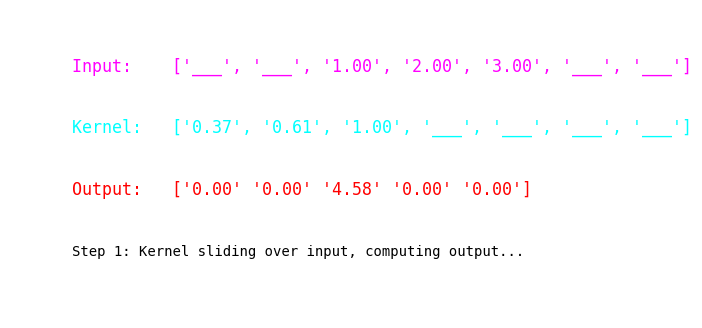

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters for the exponential decay
tau = 2.0  # Time constant for decay
input_signal = np.array([1, 2, 3])  # Input array
kernel = np.exp(-np.arange(len(input_signal)) / tau)  # Exponential decay kernel
flipped_kernel = kernel[::-1]  # Flipped kernel for convolution

# Output array initialization
output_array = np.full(len(input_signal) + len(flipped_kernel) - 1, '___', dtype=object)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis("off")

# Text placeholders for arrays
text_input = ax.text(0.1, 0.8, '', fontsize=12, color='magenta', family='monospace')
text_kernel = ax.text(0.1, 0.6, '', fontsize=12, color='cyan', family='monospace')
text_output = ax.text(0.1, 0.4, '', fontsize=12, color='red', family='monospace')
text_description = ax.text(0.1, 0.2, '', fontsize=10, color='black', family='monospace')

# Update function to fix input display and output computation
def update_fixed_input_and_output(frame):
    ax.clear()
    ax.axis("off")
    if frame < len(output_array):
        # Create the sliding representation
        padded_input = ['___'] * (len(flipped_kernel) - 1) + list(input_signal) + ['___'] * (len(flipped_kernel) - 1)
        sliding_window = padded_input[frame:frame + len(flipped_kernel)]
        
        # Compute convolution result at this step
        if '___' not in sliding_window:
            valid_input = np.array([float(val) for val in sliding_window])
            valid_kernel = np.array(flipped_kernel)
            result = np.sum(valid_input * valid_kernel)
        else:
            result = 0

        # Update output array with correct values
        if frame < len(output_array):
            output_array[frame] = f"{result:.2f}"

        # Create the aligned input and kernel text representations
        input_text = [
            f"{float(padded_input[i]):.2f}" if padded_input[i] != '___' else '___'
            for i in range(len(padded_input))
        ]
        kernel_text = [
            f"{flipped_kernel[i - frame]:.2f}" if frame <= i < frame + len(flipped_kernel) else '___'
            for i in range(len(padded_input))
        ]

        # Update text for the aligned kernel, input, and output
        text_input.set_text(f"Input:    {input_text}")
        text_kernel.set_text(f"Kernel:   {kernel_text}")
        text_output.set_text(f"Output:   {output_array}")
        text_description.set_text(f"Step {frame + 1}: Kernel sliding over input, computing output...")

        # Render texts in the plot
        ax.text(0.1, 0.8, text_input.get_text(), fontsize=12, color='magenta', family='monospace')
        ax.text(0.1, 0.6, text_kernel.get_text(), fontsize=12, color='cyan', family='monospace')
        ax.text(0.1, 0.4, text_output.get_text(), fontsize=12, color='red', family='monospace')
        ax.text(0.1, 0.2, text_description.get_text(), fontsize=10, color='black', family='monospace')

# Create the animation with corrected input and output updates
frames_fixed_input_output = len(output_array)
ani_fixed_input_output = FuncAnimation(
    fig, update_fixed_input_and_output, frames=frames_fixed_input_output, repeat=False, interval=1000
)

# Save the updated animation as a GIF
gif_path_fixed_input_output = "./fixed_input_and_output.gif"
ani_fixed_input_output.save(gif_path_fixed_input_output, writer='imagemagick', fps=1)

print("Animation saved to:", gif_path_fixed_input_output)


Animation saved to: ./fixed_input_and_output.gif


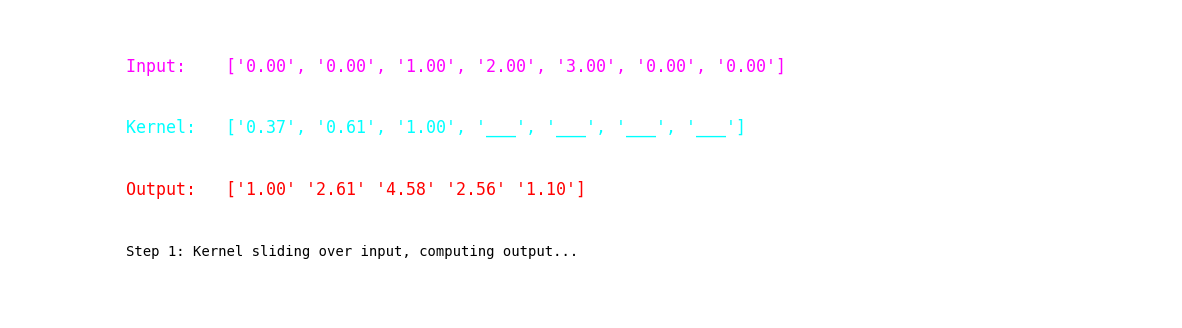

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters for the exponential decay
tau = 2.0  # Time constant for decay
input_signal = np.array([1, 2, 3])  # Input array
kernel = np.exp(-np.arange(len(input_signal)) / tau)  # Exponential decay kernel
flipped_kernel = kernel[::-1]  # Flipped kernel for convolution

# Output array initialization
output_array = np.full(len(input_signal) + len(flipped_kernel) - 1, '___', dtype=object)

# Set up the figure
fig, ax = plt.subplots(figsize=(15, 4))
ax.axis("off")

# Text placeholders for arrays
text_input = ax.text(0.1, 0.8, '', fontsize=12, color='magenta', family='monospace')
text_kernel = ax.text(0.1, 0.6, '', fontsize=12, color='cyan', family='monospace')
text_output = ax.text(0.1, 0.4, '', fontsize=12, color='red', family='monospace')
text_description = ax.text(0.1, 0.2, '', fontsize=10, color='black', family='monospace')

# Update function to fix input display and output computation
def update_fixed_input_and_output(frame):
    ax.clear()
    ax.axis("off")
    if frame < len(output_array):
        # Create the sliding representation
        padded_input = [0.0] * (len(flipped_kernel) - 1) + list(input_signal) + [0.0] * (len(flipped_kernel) - 1)
        sliding_window = padded_input[frame:frame + len(flipped_kernel)]
        
        # Compute convolution result at this step
        result = np.sum(np.array(sliding_window) * flipped_kernel)

        # Update output array with correct values
        if frame < len(output_array):
            output_array[frame] = f"{result:.2f}"

        # Create the aligned input and kernel text representations
        input_text = [
            f"{padded_input[i]:.2f}" if i < len(padded_input) else '___'
            for i in range(len(padded_input))
        ]
        kernel_text = [
            f"{flipped_kernel[i - frame]:.2f}" if frame <= i < frame + len(flipped_kernel) else '___'
            for i in range(len(padded_input))
        ]

        # Update text for the aligned kernel, input, and output
        text_input.set_text(f"Input:    {input_text}")
        text_kernel.set_text(f"Kernel:   {kernel_text}")
        text_output.set_text(f"Output:   {output_array}")
        text_description.set_text(f"Step {frame + 1}: Kernel sliding over input, computing output...")

        # Render texts in the plot
        ax.text(0.1, 0.8, text_input.get_text(), fontsize=12, color='magenta', family='monospace')
        ax.text(0.1, 0.6, text_kernel.get_text(), fontsize=12, color='cyan', family='monospace')
        ax.text(0.1, 0.4, text_output.get_text(), fontsize=12, color='red', family='monospace')
        ax.text(0.1, 0.2, text_description.get_text(), fontsize=10, color='black', family='monospace')

# Create the animation with corrected input and output updates
frames_fixed_input_output = len(output_array)
ani_fixed_input_output = FuncAnimation(
    fig, update_fixed_input_and_output, frames=frames_fixed_input_output, repeat=False, interval=1000
)

# Save the updated animation as a GIF
gif_path_fixed_input_output = "./fixed_input_and_output.gif"
ani_fixed_input_output.save(gif_path_fixed_input_output, writer='imagemagick', fps=1)

print("Animation saved to:", gif_path_fixed_input_output)


'./membrane_with_decay.gif'

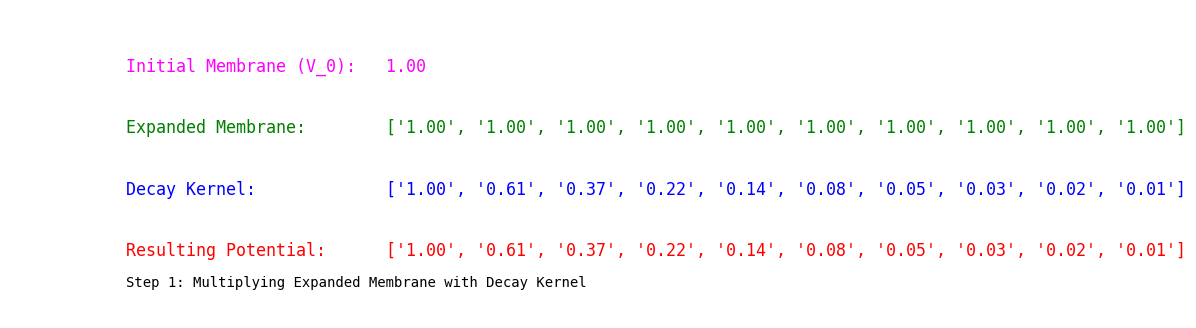

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters
V_0 = 1.0  # Initial membrane potential
tau = 2.0  # Time constant for decay
max_time_steps = 10  # Number of time steps to consider

# Generate exponential decay kernel
time_steps = np.arange(max_time_steps)
decay_kernel = np.exp(-time_steps / tau)

# Initialize empty array for results (to be computed during animation)
result_array = np.zeros(max_time_steps)

# Set up the figure
fig, ax = plt.subplots(figsize=(15, 4))
ax.axis("off")

# Text placeholders for animation
text_initial = ax.text(0.1, 0.8, '', fontsize=12, color='magenta', family='monospace')
text_expanded = ax.text(0.1, 0.6, '', fontsize=12, color='green', family='monospace')
text_decay = ax.text(0.1, 0.4, '', fontsize=12, color='blue', family='monospace')
text_result = ax.text(0.1, 0.2, '', fontsize=12, color='red', family='monospace')

# Update function for animation
def update_membrane_with_decay(frame):
    ax.clear()
    ax.axis("off")
    if frame < max_time_steps:
        # Generate the expanded membrane and compute the result
        expanded_membrane = np.ones(max_time_steps) * V_0
        result_array[frame] = expanded_membrane[frame] * decay_kernel[frame]
        
        # Convert arrays to string representations for display
        expanded_text = [f"{val:.2f}" for val in expanded_membrane]
        decay_text = [f"{val:.2f}" for val in decay_kernel]
        result_text = [f"{val:.2f}" for val in result_array]

        # Update texts
        text_initial.set_text(  f"Initial Membrane (V_0):   {V_0:.2f}")
        text_expanded.set_text( f"Expanded Membrane:        {expanded_text}")
        text_decay.set_text(    f"Decay Kernel:             {decay_text}")
        text_result.set_text(   f"Resulting Potential:      {result_text}")

        # Render texts in the plot
        ax.text(0.1, 0.8, text_initial.get_text(), fontsize=12, color='magenta', family='monospace')
        ax.text(0.1, 0.6, text_expanded.get_text(), fontsize=12, color='green', family='monospace')
        ax.text(0.1, 0.4, text_decay.get_text(), fontsize=12, color='blue', family='monospace')
        ax.text(0.1, 0.2, text_result.get_text(), fontsize=12, color='red', family='monospace')
        ax.text(0.1, 0.1, f"Step {frame + 1}: Multiplying Expanded Membrane with Decay Kernel", fontsize=10, color='black', family='monospace')

# Create the updated animation
ani_membrane_with_decay = FuncAnimation(
    fig, update_membrane_with_decay, frames=max_time_steps, repeat=False, interval=1000
)

# Save the animation as a GIF
gif_path_membrane_with_decay = "./membrane_with_decay.gif"
ani_membrane_with_decay.save(gif_path_membrane_with_decay, writer='imagemagick', fps=1)

gif_path_membrane_with_decay
